# In Class Exercise 8.1

We first import our framework. Since we are already familiar with pytorch, we will use the torch library. This will make it easy for us since we can use functions and classes other coders have already implemented.

In [0]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import numpy as np
import cv2

### Define the hyper-parameter and load the training dataset

hyperparameters we define in here

- img_size
- batch_size (how big is one batch. This splits our dataset into equal pieces that we will feed into our neural network)
- train_epoch (How long will we train)
- learning rate
- dataset we will use


In [2]:
# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 10

# data_loader
img_size = 32
transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In here we are defining some functions that we will use later. Functions are very useful and you should write your functions whenever your code benefits from it. You should always declare your functions first in your script.

- normal_init (we will use this function to initialize our weights)
- show_result (outputs the images to a .png image)
- show the loss curve

In [3]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# fixed noise & label
temp_z_ = torch.randn(10, 100)
fixed_z_ = temp_z_
fixed_y_ = torch.zeros(10, 1)
for i in range(9):
    fixed_z_ = torch.cat([fixed_z_, temp_z_], 0)
    temp = torch.ones(10, 1) + i
    fixed_y_ = torch.cat([fixed_y_, temp], 0)

fixed_z_ = fixed_z_.view(-1, 100, 1, 1)
fixed_y_label_ = torch.zeros(100, 10)
fixed_y_label_.scatter_(1, fixed_y_.type(torch.LongTensor), 1)
fixed_y_label_ = fixed_y_label_.view(-1, 10, 1, 1)
fixed_z_, fixed_y_label_ = Variable(fixed_z_.cuda()), Variable(fixed_y_label_.cuda())

def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    G.eval()
    with torch.no_grad():
      test_images = G(fixed_z_, fixed_y_label_)
    G.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = True, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


# Define the generator and discriminator

In [0]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(input)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1_1 = nn.Conv2d(1, d//2, 4, 2, 1)
        self.conv1_2 = nn.Conv2d(10, d//2, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d * 4, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))

        return x

### Create an instance of our generator and discriminator

In [0]:
# network
G = generator(128)
D = discriminator(128)

G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

G.cuda()
D.cuda()


# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

### Define which optimizer we will use for the optimization of our neural network

In [0]:
# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

### Start to training and save the reconstructed images

training start!


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/10] - ptime: 98.80, loss_d: 0.764, loss_g: 3.087
[2/10] - ptime: 103.23, loss_d: 0.780, loss_g: 2.378
[3/10] - ptime: 106.88, loss_d: 1.103, loss_g: 1.523
[4/10] - ptime: 107.56, loss_d: 1.152, loss_g: 1.351
[5/10] - ptime: 107.71, loss_d: 1.125, loss_g: 1.332
[6/10] - ptime: 107.81, loss_d: 1.053, loss_g: 1.479
[7/10] - ptime: 107.93, loss_d: 0.938, loss_g: 1.678
[8/10] - ptime: 107.87, loss_d: 0.795, loss_g: 1.926
[9/10] - ptime: 107.97, loss_d: 0.664, loss_g: 2.198
[10/10] - ptime: 107.88, loss_d: 0.578, loss_g: 2.500


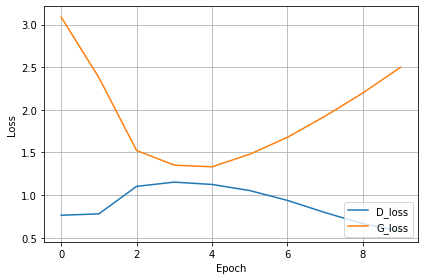

In [7]:
# results save folder
root = 'cDCGAN_results/'
model = 'cDCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# label preprocess
onehot = torch.zeros(10, 10)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1).view(10, 10, 1, 1)
fill = torch.zeros([10, 10, img_size, img_size])
for i in range(10):
    fill[i, i, :, :] = 1

print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []

    epoch_start_time = time.time()
    y_real_ = torch.ones(batch_size)
    y_fake_ = torch.zeros(batch_size)
    y_real_, y_fake_ = Variable(y_real_.cuda()), Variable(y_fake_.cuda())
    for x_, y_ in train_loader:
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        if mini_batch != batch_size:
            y_real_ = torch.ones(mini_batch)
            y_fake_ = torch.zeros(mini_batch)
            y_real_, y_fake_ = Variable(y_real_.cuda()), Variable(y_fake_.cuda())

        y_fill_ = fill[y_]
        y_fill_ = fill[y_]
        x_, y_fill_ = Variable(x_.cuda()), Variable(y_fill_.cuda())

        D_result = D(x_, y_fill_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).squeeze()
        y_label_ = onehot[y_]
        y_fill_ = fill[y_]
        z_, y_label_, y_fill_ = Variable(z_.cuda()), Variable(y_label_.cuda()), Variable(y_fill_.cuda())

        G_result = G(z_, y_label_)
        D_result = D(G_result, y_fill_).squeeze()

        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.data)

        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).squeeze()
        y_label_ = onehot[y_]
        y_fill_ = fill[y_]
        z_, y_label_, y_fill_ = Variable(z_.cuda()), Variable(y_label_.cuda()), Variable(y_fill_.cuda())

        G_result = G(z_, y_label_)
        D_result = D(G_result, y_fill_).squeeze()

        G_train_loss = BCE_loss(D_result, y_real_)

        G_train_loss.backward()
        G_optimizer.step()

        
        G_losses.append(G_train_loss.data)
        

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'

    show_result((epoch+1), save=True, path=fixed_p)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []

for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

# Define the noise and label to generate the result.

In [8]:
# fixed noise & label
fixed_z_2 = torch.randn(10, 100)
fixed_z_2 = fixed_z_2.view(-1, 100, 1, 1)

one_hot = [[1,0,0,0,0,0,0,0,0,0],
           [0,1,0,0,0,0,0,0,0,0],
           [0,0,1,0,0,0,0,0,0,0],
           [0,0,0,1,0,0,0,0,0,0],
           [0,0,0,0,1,0,0,0,0,0],
           [0,0,0,0,0,1,0,0,0,0],
           [0,0,0,0,0,0,1,0,0,0],
           [0,0,0,0,0,0,0,1,0,0],
           [0,0,0,0,0,0,0,0,1,0],
           [0,0,0,0,0,0,0,0,0,1]]


one_hot_arr = np.array(one_hot)

fixed_y_label_2 = torch.from_numpy(one_hot_arr)

fixed_y_label_2 = fixed_y_label_2.view(-1, 10, 1, 1)

fixed_y_label_2 = fixed_y_label_2.float()
fixed_z_2 = fixed_z_2.float()

fixed_z_2, fixed_y_label_2 = Variable(fixed_z_2.cuda()), Variable(fixed_y_label_2.cuda())

def show_result_2(save_name='test', show = False, save = False, isFix=False):
       
    G.eval()

    with torch.no_grad():
        test_images = G(fixed_z_2, fixed_y_label_2)

    G.train()
    
    pic = to_img(test_images.cpu().data)
    img_path= './cDCGAN_results/output_{}.png'.format(save_name)
    save_image(pic,img_path)
    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(-1, 1, 32, 32)
    return x

show_result_2()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
